In [5]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
from PIL import Image
import os
from tqdm import tqdm

In [6]:
LABELS2OG_CLASSES = {
  0: 0,    # "unlabeled", and others ignored
  1: 10,     # "car"
  2: 11,     # "bicycle"
  3: 15,     # "motorcycle"
  4: 18,     # "truck"
  5: 20,     # "other-vehicle"
  6: 30,     # "person"
  7: 31,     # "bicyclist"
  8: 32,     # "motorcyclist"
  9: 40,     # "road"
  10: 44,    # "parking"
  11: 48,    # "sidewalk"
  12: 49,    # "other-ground"
  13: 50,    # "building"
  14: 51,    # "fence"
  15: 70,    # "vegetation"
  16: 71,    # "trunk"
  17: 72,    # "terrain"
  18: 80,    # "pole"
  19: 81    # "traffic-sign"
}

In [7]:
# Create the mapping between original labels
OG_CLASSES2LABELS = {
  0: 0,     # "unlabeled"
  1: 0,     # "outlier" mapped to "unlabeled" --------------------------mapped
  10: 1,     # "car"
  11: 2,     # "bicycle"
  13: 5,     # "bus" mapped to "other-vehicle" --------------------------mapped
  15: 3,     # "motorcycle"
  16: 5,     # "on-rails" mapped to "other-vehicle" ---------------------mapped
  18: 4,     # "truck"
  20: 5,     # "other-vehicle"
  30: 6,     # "person"
  31: 7,     # "bicyclist"
  32: 8,     # "motorcyclist"
  40: 9,     # "road"
  44: 10,    # "parking"
  48: 11,    # "sidewalk"
  49: 12,    # "other-ground"
  50: 13,    # "building"
  51: 14,    # "fence"
  52: 0,    # "other-structure" mapped to "unlabeled" ------------------mapped
  60: 9,     # "lane-marking" to "road" ---------------------------------mapped
  70: 15,    # "vegetation"
  71: 16,    # "trunk"
  72: 17,    # "terrain"
  80: 18,    # "pole"
  81: 19,    # "traffic-sign"
  99: 0,     # "other-object" to "unlabeled" ----------------------------mapped
  252: 1,    # "moving-car" to "car" ------------------------------------mapped
  253: 7,    # "moving-bicyclist" to "bicyclist" ------------------------mapped
  254: 6,    # "moving-person" to "person" ------------------------------mapped
  255: 8,    # "moving-motorcyclist" to "motorcyclist" ------------------mapped
  256: 5,    # "moving-on-rails" mapped to "other-vehicle" --------------mapped
  257: 5,    # "moving-bus" mapped to "other-vehicle" -------------------mapped
  258: 4,    # "moving-truck" to "truck" --------------------------------mapped
  259: 5    # "moving-other"-vehicle to "other-vehicle" ----------------mapped
}

In [8]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

class UNET(nn.Module):

    def __init__(self, in_channels=3, classes=1):
        super(UNET, self).__init__()
        self.layers = [in_channels, 64, 128, 256, 512, 1024]

        self.double_conv_downs = nn.ModuleList(
            [self.__double_conv(layer, layer_n) for layer, layer_n in zip(self.layers[:-1], self.layers[1:])])

        self.up_trans = nn.ModuleList(
            [nn.ConvTranspose2d(layer, layer_n, kernel_size=2, stride=2)
             for layer, layer_n in zip(self.layers[::-1][:-2], self.layers[::-1][1:-1])])

        self.double_conv_ups = nn.ModuleList(
        [self.__double_conv(layer, layer//2) for layer in self.layers[::-1][:-2]])

        self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.final_conv = nn.Conv2d(64, classes, kernel_size=1)


    def __double_conv(self, in_channels, out_channels):
        conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        return conv

    def forward(self, x):
        # down layers
        concat_layers = []
        for down in self.double_conv_downs:
            x = down(x)
            if down != self.double_conv_downs[-1]:
                concat_layers.append(x)
                x = self.max_pool_2x2(x)
        concat_layers = concat_layers[::-1]
        # up layers
        for up_trans, double_conv_up, concat_layer  in zip(self.up_trans, self.double_conv_ups, concat_layers):
            x = up_trans(x)
            if x.shape != concat_layer.shape:
                x = TF.resize(x, concat_layer.shape[2:])
            concatenated = torch.cat((concat_layer, x), dim=1)
            x = double_conv_up(concatenated)
        x = self.final_conv(x)
        return x

In [9]:
model = UNET(in_channels=1, classes = 20)
model.load_state_dict(torch.load('models/best_model.pth'))
model = model.cuda()

In [10]:
class SemanticKittiDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, cls_map: dict = OG_CLASSES2LABELS):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)
        self.mask_mapping = cls_map

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.images[idx])
        mask_name = os.path.join(self.mask_dir, f"m{self.images[idx].replace('png', 'npy')[1:]}")
        image = Image.open(img_name)
        # there is a general problem with loading depth 16bit image into PIL
        # it fixed the issue, but maybe there exist a better solution
        image = image.convert("I")
        mask = np.loadtxt(mask_name, delimiter=" ")
        # map the original mask into proper ranges
        mask = np.vectorize(self.mask_mapping.get)(mask).astype(np.uint8)
        sample = {'image': image, 'mask': mask}
        if self.transform:
            sample = self.transform(sample)
        return sample

In [11]:
class Transformations(object):
    """Apply Resize and ToTensor transformations."""
    def __init__(self, output_size):
        self.output_size = output_size

    def __call__(self, sample):
        image, mask = sample['image'], sample['mask']
        resize = transforms.Resize(self.output_size, interpolation=Image.NEAREST)
        # image = resize(image)
        mask = Image.fromarray(mask)
        # mask = resize(mask)
        image = np.array(image, dtype=np.float32)
        mask = np.array(mask, dtype=np.int64)
        image /= 65535.0  # normalize 16-bit image
        image = image.reshape((1, image.shape[0], image.shape[1]))
        return {'image': torch.from_numpy(image),
                'mask': torch.from_numpy(mask)}

In [12]:
# images are resized into 256x256
test_image_dir = 'data/lidar_png/01/'
test_mask_dir = 'data/masks/01/'
test_dataset = SemanticKittiDataset(image_dir=test_image_dir, mask_dir=test_mask_dir,
                                           transform=Transformations(output_size=(256, 256)),
                                           cls_map = OG_CLASSES2LABELS)

In [13]:
from sklearn.metrics import classification_report, confusion_matrix

In [14]:
def evaluate_model(model, test_dataset, batch_size=16, num_classes=20):
    # Ensure the model is in evaluation mode
    model.eval()
    
    # Create a DataLoader for the test dataset
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Initialize lists to store ground truth and predictions
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating"):
            images = batch['image'].cuda()
            masks = batch['mask'].cuda()
            
            # Get model predictions
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            
            # Append the predictions and ground truth to lists
            all_preds.append(preds.cpu().numpy())
            all_labels.append(masks.cpu().numpy())
    
    # Concatenate all predictions and labels
    all_preds = np.concatenate(all_preds, axis=0).flatten()
    all_labels = np.concatenate(all_labels, axis=0).flatten()

    return all_preds, all_labels

In [15]:
predictions, labels = evaluate_model(model, test_dataset, batch_size=16, num_classes=20)

Evaluating: 100%|██████████| 69/69 [00:17<00:00,  4.04it/s]


In [16]:
LABELS2NAMES = {
  0: "unlabeled",
  1: "car",
  2: "bicycle",
  3: "motorcycle",
  4: "truck",
  5: "other-vehicle",
  6: "person",
  7: "bicyclist",
  8: "motorcyclist",
  9: "road",
  10: "parking",
  11: "sidewalk",
  12: "other-ground",
  13: "building",
  14: "fence",
  15: "vegetation",
  16: "trunk",
  17: "terrain",
  18: "pole",
  19: "traffic-sign"
}

In [17]:
labels[labels == 3]

array([], dtype=int64)

In [18]:
names = LABELS2NAMES.values()
labels_indices = list(LABELS2NAMES.keys())

In [19]:
classification_rep = classification_report(labels, predictions, labels=labels_indices ,target_names=names)

/opt/conda/envs/mp_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/envs/mp_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/envs/mp_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/env

In [20]:
print(classification_rep)

               precision    recall  f1-score   support

    unlabeled       0.96      0.99      0.97  25473086
          car       0.07      0.93      0.13    387654
      bicycle       0.00      0.00      0.00         0
   motorcycle       0.00      0.00      0.00         0
        truck       0.00      0.00      0.00         0
other-vehicle       0.00      0.00      0.00     25530
       person       0.00      0.00      0.00         0
    bicyclist       0.00      0.00      0.00         0
 motorcyclist       0.00      0.00      0.00      1313
         road       0.90      0.72      0.80  20069923
      parking       0.00      0.00      0.00         0
     sidewalk       0.00      0.32      0.00       118
 other-ground       0.00      0.00      0.00   1296562
     building       0.09      0.21      0.13     79689
        fence       0.60      0.21      0.31   7226409
   vegetation       0.67      0.66      0.67  10744241
        trunk       0.05      0.03      0.04     25762
      ter

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [22]:
# Exclude the "unlabeled" class (class 0)
valid_indices = [i for i, label in enumerate(labels) if label != 0]
filtered_labels = labels[valid_indices]
filtered_predictions = predictions[valid_indices]

In [23]:
cm = confusion_matrix(filtered_labels, filtered_predictions, labels=[i for i in range(1,20)])

In [24]:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
# replace NaN values with 0
cm_normalized = np.nan_to_num(cm_normalized)

/tmp/ipykernel_9554/2045805203.py:1: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


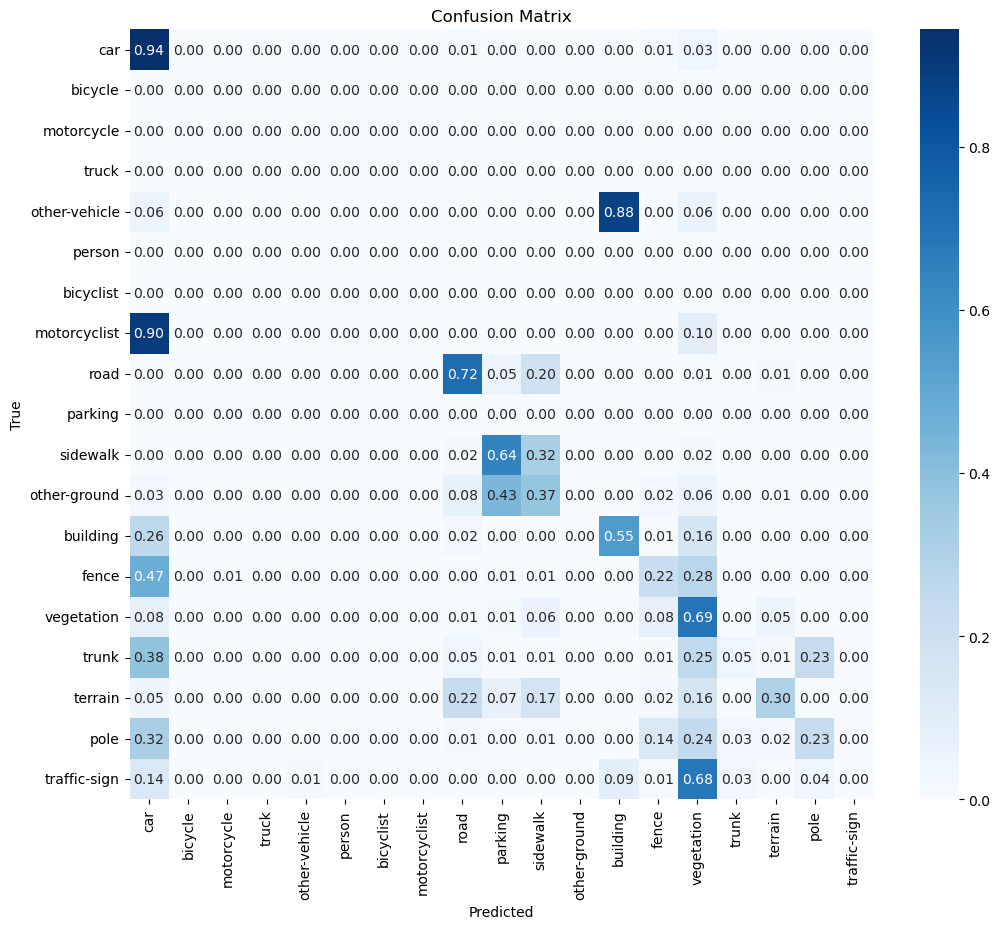

In [25]:
plot_confusion_matrix(cm_normalized, class_names=list(names)[1:]) # DEBUG: fix normalization

In [28]:
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

def compute_metrics(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    
    TP = np.diag(cm)
    FP = cm.sum(axis=0) - TP
    FN = cm.sum(axis=1) - TP
    TN = cm.sum() - (FP + FN + TP)

    IoU = TP / (TP + FP + FN)
    mean_IoU = np.nanmean(IoU)
    
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    return {
        'IoU': IoU,
        'mean_IoU': mean_IoU,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }

In [29]:
stats = compute_metrics(filtered_labels, filtered_predictions)

/opt/conda/envs/mp_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/envs/mp_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [33]:
print("Precision: ", stats["Precision"])
print("Recall: ", stats["Recall"])
print("F1 Score: ", stats["F1 Score"])

Precision:  0.7369855260675101
Recall:  0.5439499764898929
F1 Score:  0.6062406132328523
